In [ ]:
# Importing required libraries

import time

from bs4 import BeautifulSoup
from selenium import webdriver
from pymongo import MongoClient

import random

from datetime import datetime
import re

In [ ]:
# Creating a connection to MongoDB
client = MongoClient('localhost', 27017)
db = client['news']
collection = db['elespectador']

In [ ]:
# Base URL of the site to be analyzed
SITE_URL = 'https://www.elespectador.com'

In [ ]:
# Firefox web driver path
# Download the driver for you S.O. here: https://github.com/mozilla/geckodriver/releases
DRIVER_PATH = './geckodriver'

In [ ]:
# Creating a new firefox window
browser = webdriver.Firefox(executable_path = DRIVER_PATH)

In [ ]:
def make_request(browser, relative_path):
    # Making the request and rendering the browser
    browser.get(SITE_URL + relative_path)
    
    # Simulating vertical scrolling for handling lazy load
    check_height = browser.execute_script('return document.body.scrollHeight;')
    while True:
        browser.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(3)
        height = browser.execute_script('return document.body.scrollHeight;')
        if height == check_height: 
            break 
        check_height = height
    
    # Getting HTML content and passing it to BeautifulSoup for scraping analysis
    return BeautifulSoup(browser.page_source, 'html.parser')

In [ ]:
def getNews(browser, path, category):
  # Getting HTML content for news listing page
  soup = make_request(browser, path)
  # Finding the section where news are contained 
  layout = soup.find(class_ = 'Layout-flexAds')
  sections= layout.find_all('section', recursive= True)
  cards= []
  for s in sections:
      cards= cards + (s.find_all(class_ = 'Card'))
  print('Sections lenght', len(sections))
  print('Cards lenght', len(cards))
  '''
  # Getting blocks from layout
  blocks = layout.find('section').find_all(recursive = False)
  print(len(blocks)) # 3 blocks founded, 2 for news and 1 for pagintion
  # Finding and concatenating news cards
  cards = blocks[0].find_all(class_ = 'Card') + blocks[1].find_all(class_ = 'Card')
  print(len(cards))
  '''
  # Building a list with title and relative path of the news founded
  news = []
  for card in cards:
      news.append({
          'title': card.find('h2', class_ = 'Card-Title').find('a').get_text(),
          'relative_path': card.find('h2', class_ = 'Card-Title').find('a')['href']
      })
  #print(news)
  for n in news:
      # Getting HTML content for news page
      soup = make_request(browser, n['relative_path'])
      # Extracting news metadata
      dateStr= soup.find(class_ = 'ArticleHeader-Date').get_text()
      dateStr = dateStr.replace(u'\xa0', u' ')
      #print(dateStr)
      spl= re.split('((a|p). m.)', dateStr)
      #print(spl)
      if spl[2] == 'a':
        dateStr= spl[0]+'am'
      else:
        dateStr= spl[0]+'pm'
      date= datetime.strptime(dateStr, "%d %b %Y  - %I:%M %p")
      n['datetime'] = date
      n['author'] = soup.find(class_ = 'ACredit-Author').get_text()
      n['summary'] = soup.find(class_ = 'ArticleHeader-Hook').get_text()
      n['category'] = re.search('\\w+', category).group()
    
      # Extracting and concatenating news full text
      paragraphs = soup.find_all(class_ = 'font--secondary')
      n['full_text'] = ' '.join([p.get_text() for p in paragraphs])
  #print(news)
  return news

In [ ]:
def getCategories(browser, path):
  browser.get(path)
  headerCat= browser.find_element_by_class_name('Header-Icon')
  headerCat.click()
  time.sleep(3)
  soup= BeautifulSoup(browser.page_source, 'html.parser')
  menu= soup.find(class_= 'Menu-Container')
  items= menu.find_all(class_= 'Menu-Item Menu-Item_depth_1')
  p= []
  for i in range(len(items)):
    p.append(items[i].find('a')['href'])
    if i == 14:
      break
  print(len(items))
  print(p)
  f= []
  for i in range(5):
    c= random.choice(p)
    f.append(c)
    p.remove(c)
  print(f)
  return f
categories= getCategories(browser, SITE_URL)

In [ ]:
def getFinalNews(browser, category, p):
  news = []
  try:
    for n in range(1,p+1):
      #print('the value of n Is:::::::', n)
      if n > 1:
        #print('N is greater than 1')
        news= news + getNews(browser, f'/archivo{category}{n}', category)
      else:
        #print('N is lower than 1')
        news= news + getNews(browser, f'/archivo{category}', category)
  except:
    news= news + getNews(browser, f'/archivo{category}', category)
  return news

news= []
p= int(input('Enter the number of pages from which you would like to receive news.\n It needs to be greater than 1 otherwise it would take the first page.'))
for c in categories:
  news= news + getFinalNews(browser, c, p)
print(len(news))

In [ ]:
# Storing extracted information for further analysis
collection.insert_many(news)

In [55]:
#Second part
import nltk
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [40]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Santi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [131]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
#Tokenize

cleanC= []
for c in categories:
    cleanC.append(re.search('\\w+', c).group())
    
#print(cleanC)

data= {}
for k in collection.find_one().keys():
    data[k]= []

#print(data)
for n in collection.find():
    for k in n.keys():
        data[k].append(n[k])
        
df= pd.DataFrame(data)
#print(df.info())

tokns = [nltk.word_tokenize(t.lower()) for t in df['full_text'] ]
#print(tokns)

stop_words = set(nltk.corpus.stopwords.words("spanish"))
#print(stop_words)

swtk= [[w for w in t if w not in stop_words] for t in tokns]
#print(type(swtk))

df['nonStopWords']= swtk
#print(df.head(5))

C:\Users\Santi\AppData\Local\Temp/ipykernel_13284/3332214188.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


category


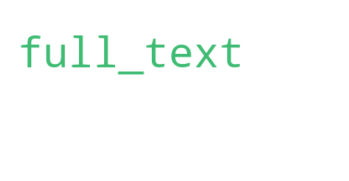

colombia


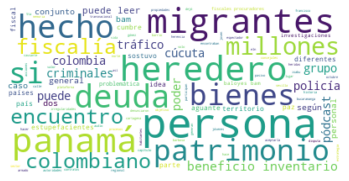

opinion


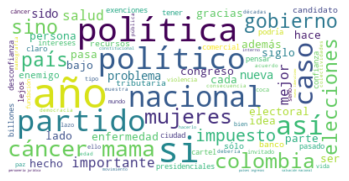

politica


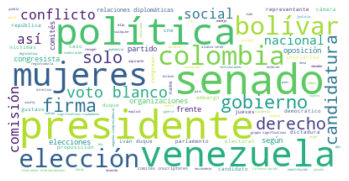

tecnologia


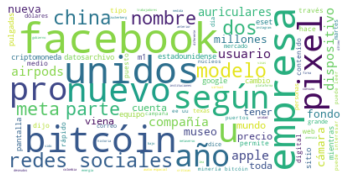

In [125]:
#Group by category to show the word cloud

tc={}
cat= df.groupby('category')
for c in cat:
    tc[c[0]]= c[1]['nonStopWords'].tolist() 
#print(tc)

for k in tc.keys():
    w= []
    for ws in tc[k]:
        w= w+ws
    tc[k]= w
    
#print(tc)

for k in tc.keys():
    print(k)
    wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(tc[k]))

    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

2021-10-11 00:00:00


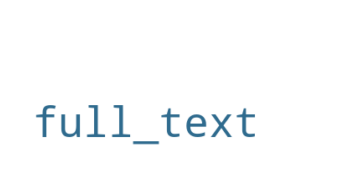

2021-10-18 00:00:00


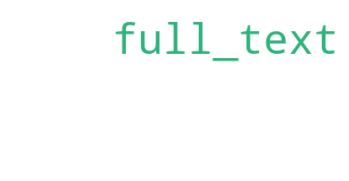

2021-10-25 00:00:00


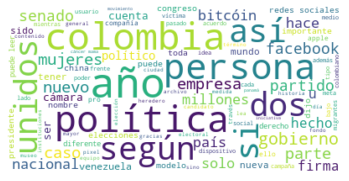

In [132]:
#Group by date

#n= {'title': 'prueba', 'relative_path': 'prueba', 'datetime': datetime(2021,10,15,1,1,1,1), 'author': 'test', 'summary': 'test', 'category': 'category', 'full_text': 'full_text'}
#collection.insert_one(n)
dfdates= df.groupby(pd.Grouper(key='datetime', freq='W-MON'))
#print(type(dfdates))
tc= {}
for c in dfdates:
    tc[c[0]]= c[1]['nonStopWords'].tolist() 

for k in tc.keys():
    w= []
    for ws in tc[k]:
        w= w+ws
    tc[k]= w
    
#print(tc)

for k in tc.keys():
    print(k)
    try:
        wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(tc[k]))

        plt.imshow(wordcloud, interpolation = "bilinear")
        plt.axis("off")
        plt.show()
    except:
        pass